In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader

import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from ..CustomDatasets import SCAEDataset

In [3]:
train_dataset = SCAEDataset(root_dir="../data/train")
val_dataset = SCAEDataset(root_dir="../data/val")
test_dataset = SCAEDataset(root_dir="../data/test")


print(f"Dataset size: {len(train_dataset)}")

# Getting the first sample
image, label = train_dataset[0]
print(f"First image shape: {image.shape}, Label: {label}")


Dataset size: 22099
First image shape: torch.Size([1, 64, 64]), Label: 1


In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)

In [5]:
### Define the SCAE as per the paper, although imo, it is very basic
class StackedConvAutoencoder(nn.Module):
    def __init__(self):
        super(StackedConvAutoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)  # Output: 32x32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # Output: 16x16
        
        # Decoder
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)  # Output: 16x16
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: 32x32
        
        
    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x, indices = self.pool(x)
        
        # Decoder
        x = self.unpool(x, indices)
        x = F.relu(self.conv2(x))
        return x


In [6]:
lr = 0.001

model = StackedConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

StackedConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [7]:
num_epochs = 100  # Number of epochs to train for
best_val_loss = float('inf')

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device).float()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = 0.0
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device).float()
            
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f'Validation Loss: {val_loss:.4f}')
    
    # Check if the current validation loss is the best
    if val_loss < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        # Save model
        torch.save(model.state_dict(), '../models/SCAE_best.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 183.7984
Validation Loss: 58.5028
Validation loss decreased (inf --> 58.5028). Saving model...
Epoch [2/100], Train Loss: 49.6095
Validation Loss: 42.8358
Validation loss decreased (58.5028 --> 42.8358). Saving model...
Epoch [3/100], Train Loss: 40.5175
Validation Loss: 38.7223
Validation loss decreased (42.8358 --> 38.7223). Saving model...
Epoch [4/100], Train Loss: 37.6290
Validation Loss: 36.3347
Validation loss decreased (38.7223 --> 36.3347). Saving model...
Epoch [5/100], Train Loss: 35.7216
Validation Loss: 34.7824
Validation loss decreased (36.3347 --> 34.7824). Saving model...
Epoch [6/100], Train Loss: 33.6590
Validation Loss: 33.0247
Validation loss decreased (34.7824 --> 33.0247). Saving model...
Epoch [7/100], Train Loss: 33.3013
Validation Loss: 33.3622
Epoch [8/100], Train Loss: 33.7112
Validation Loss: 33.1705
Epoch [9/100], Train Loss: 33.1845
Validation Loss: 32.7803
Validation loss decreased (33.0247 --> 32.7803). Saving model...
Epoch [1

In [8]:
model.load_state_dict(torch.load('../models/SCAE_best.pth'))

<All keys matched successfully>

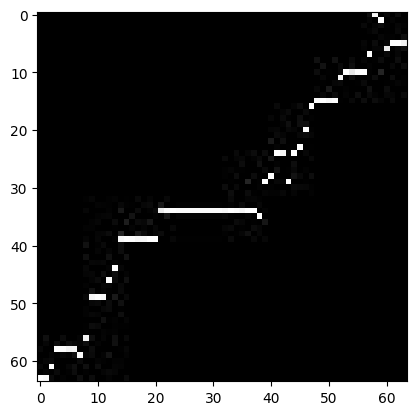

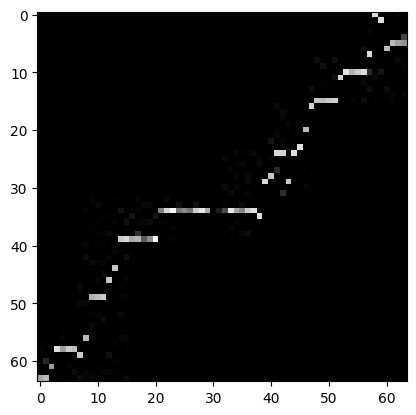

Artifact plot


In [11]:
import matplotlib.pyplot as plt

def plot_image(tensor):
    img = tensor.squeeze().cpu()
    img_np = img.numpy()

    # Display the image
    plt.imshow(img_np, cmap='gray')
    plt.show()


input_tensor = data[0][0].float().to(device) # Example input
plot_image(input_tensor)

with torch.no_grad():
    output = model(input_tensor)
    plot_image(output)

print('Artifact plot') if data[1][0]==1 else print('Non-Artifact plot')


In [14]:
input_tensor.shape

torch.Size([1, 64, 64])

In [15]:
model

OrderedDict([('conv1.weight',
              tensor([[[[ 1.3235e+00, -1.5402e+00, -8.9588e-01],
                        [-1.7064e+00,  2.3295e-02, -2.2278e+00],
                        [ 2.6217e-01, -1.7914e+00,  7.2137e-02]]],
              
              
                      [[[-5.8643e-01,  4.6440e-01,  1.1313e-01],
                        [ 9.9650e-02, -6.2853e-01, -8.0847e-01],
                        [ 2.3099e-01,  5.6321e-02,  2.7665e-02]]],
              
              
                      [[[ 6.6666e-02,  4.1223e-01, -6.5639e-01],
                        [-1.7377e-01, -3.3647e-02, -8.4212e-01],
                        [-6.5551e-01, -9.6120e-01,  9.9061e-01]]],
              
              
                      [[[ 2.3226e-01,  4.4481e-01, -1.9284e+00],
                        [ 2.5981e-01,  7.6620e-01,  6.3825e-02],
                        [ 5.3522e-02, -9.3281e-01, -9.8657e-01]]],
              
              
                      [[[-1.6729e+00,  2.3230e-03,  6.4780e-02